In [342]:
import numpy as np
import cv2
import glob
import argparse
import sys
import matplotlib.pyplot as plt
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
image_size = (2048,2448)

Cammera Calibaration done for left and right cammera to find each cammera's cammera matrix and distortion coefficients

In [343]:
def load_coefficients(path):
    """ Loads camera matrix and distortion coefficients. """
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode("K").mat()
    dist_matrix = cv_file.getNode("D").mat()

    cv_file.release()
    return [camera_matrix, dist_matrix]


def load_stereo_coefficients(path):
    """ Loads stereo matrix coefficients. """
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    K1 = cv_file.getNode("K1").mat()
    D1 = cv_file.getNode("D1").mat()
    K2 = cv_file.getNode("K2").mat()
    D2 = cv_file.getNode("D2").mat()
    R = cv_file.getNode("R").mat()
    T = cv_file.getNode("T").mat()
    E = cv_file.getNode("E").mat()
    F = cv_file.getNode("F").mat()
    R1 = cv_file.getNode("R1").mat()
    R2 = cv_file.getNode("R2").mat()
    P1 = cv_file.getNode("P1").mat()
    P2 = cv_file.getNode("P2").mat()
    Q = cv_file.getNode("Q").mat()

    cv_file.release()
    return [K1, D1, K2, D2, R, T, E, F, R1, R2, P1, P2, Q]

In [344]:
K1, D1 = load_coefficients('Parameters/cameraparameters_left.txt')
K2, D2 = load_coefficients('Parameters/cameraparameters_right.txt')
K1 ,D1,K2,D2, R ,T ,E,F,R1,R2,P1,P2,Q = load_stereo_coefficients('Parameters/cameraparameters.txt')

In [345]:

imgL1 = cv2.imread('SceneImages/SceneImages_left/left_1.bmp',cv2.IMREAD_GRAYSCALE)
imgL2 = cv2.imread('SceneImages/SceneImages_left/left_2.bmp',cv2.IMREAD_GRAYSCALE)
imgL3 = cv2.imread('SceneImages/SceneImages_left/left_3.bmp',cv2.IMREAD_GRAYSCALE)


imgR1 = cv2.imread('SceneImages/SceneImages_right/right_1.bmp',cv2.IMREAD_GRAYSCALE)
imgR2 = cv2.imread('SceneImages/SceneImages_right/right_2.bmp',cv2.IMREAD_GRAYSCALE)
imgR3 = cv2.imread('SceneImages/SceneImages_right/right_3.bmp',cv2.IMREAD_GRAYSCALE)

h1,  w1 = imgL1.shape[:2]
h2,  w2 = imgR1.shape[:2]

mapx1, mapy1 = cv2.initUndistortRectifyMap(K1, D1, R1, P1, (h1,w1), cv2.CV_32FC1)


Left_rectified1 = cv2.remap(imgL1, mapx1, mapy1, cv2.INTER_LINEAR,cv2.BORDER_CONSTANT)
Left_rectified2 = cv2.remap(imgL2, mapx1, mapy1, cv2.INTER_LINEAR,cv2.BORDER_CONSTANT)
Left_rectified3 = cv2.remap(imgL3, mapx1, mapy1, cv2.INTER_LINEAR,cv2.BORDER_CONSTANT)


mapx2, mapy2 = cv2.initUndistortRectifyMap(K2, D2, R2,P2,(h2,w2), cv2.CV_32FC1)
 
Right_rectified1 = cv2.remap(imgR1, mapx2, mapy2, cv2.INTER_LINEAR,cv2.BORDER_CONSTANT)
Right_rectified2 = cv2.remap(imgR2, mapx2, mapy2, cv2.INTER_LINEAR,cv2.BORDER_CONSTANT)
Right_rectified3 = cv2.remap(imgR3, mapx2, mapy2, cv2.INTER_LINEAR,cv2.BORDER_CONSTANT)



In [346]:

sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(imgL1,None)

kp2, des2 = sift.detectAndCompute(imgR1,None)

#print(des1)
#print(des2)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. 
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    imgL1, kp1, imgR1, kp2, matches, None, **draw_params)
key_point_matches = cv2.resize(keypoint_matches, (960, 940)) 
   
#cv2.imshow("Keypoint matches", key_point_matches)
#cv2.waitKey(0)


In [347]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [348]:
# ------------------------------------------------------------
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

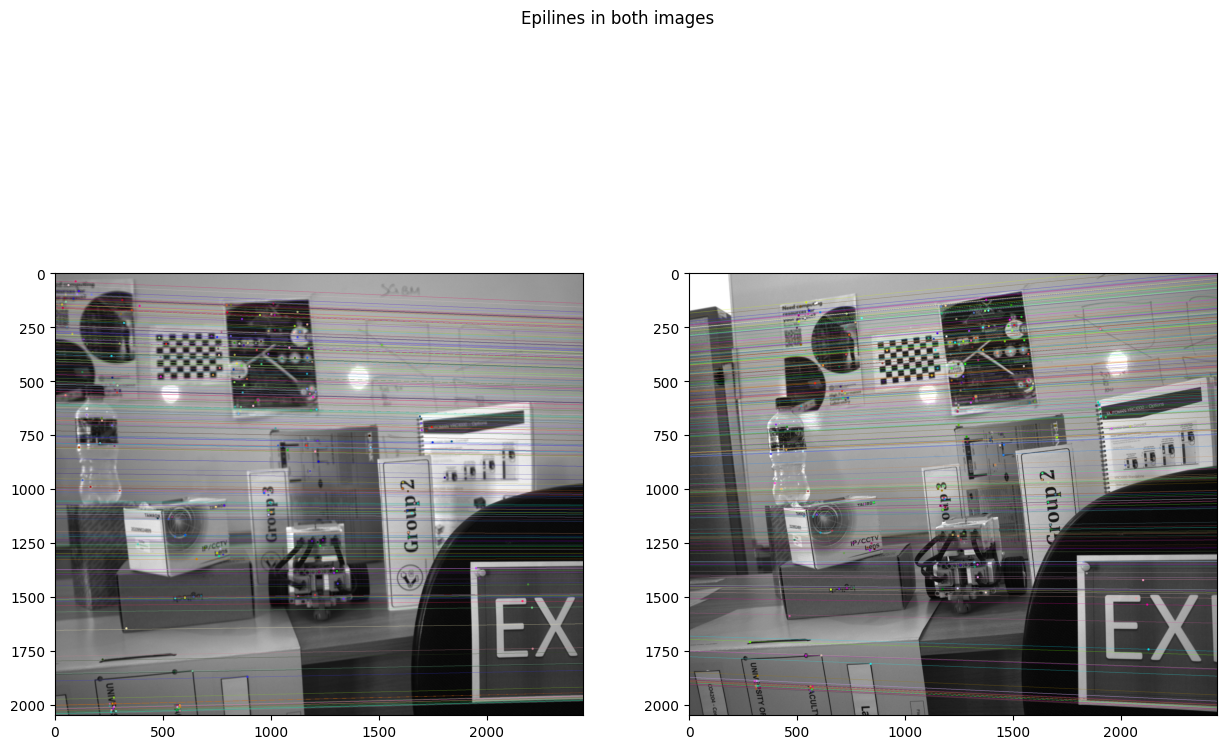

In [349]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(imgL1, imgR1, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(imgR1, imgL1, lines2, pts2, pts1)

epilines = cv2.resize(img5, (960, 940))
#cv2.imshow("Keypoint matches", epilines)
#cv2.waitKey(10000)
#cv2.destroyAllWindows()
plt.figure(figsize=(15, 10),linewidth=2.0)
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.show()

In [350]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = imgL1.shape
h2, w2 = imgR1.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1)
)

In [351]:
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv2.warpPerspective(imgL1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(imgR1, H2, (w2, h2))
cv2.imwrite("rectified_1.png", img1_rectified)
cv2.imwrite("rectified_2.png", img2_rectified)

True

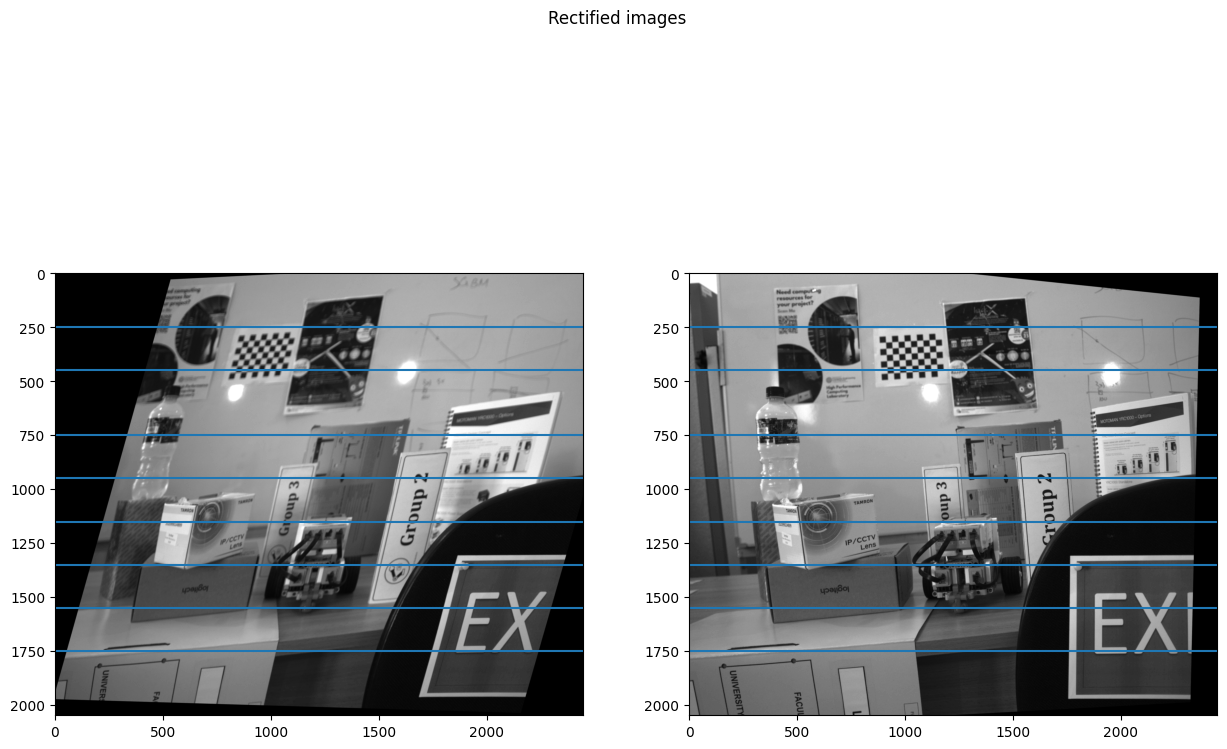

In [352]:
# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
axes[0].axhline(750)
axes[1].axhline(750)
axes[0].axhline(950)
axes[1].axhline(950)
axes[0].axhline(1150)
axes[1].axhline(1150)
axes[0].axhline(1350)
axes[1].axhline(1350)
axes[0].axhline(1550)
axes[1].axhline(1550)
axes[0].axhline(1750)
axes[1].axhline(1750)
plt.suptitle("Rectified images")
plt.savefig("./Outputs/rectified_images.png")
plt.show()

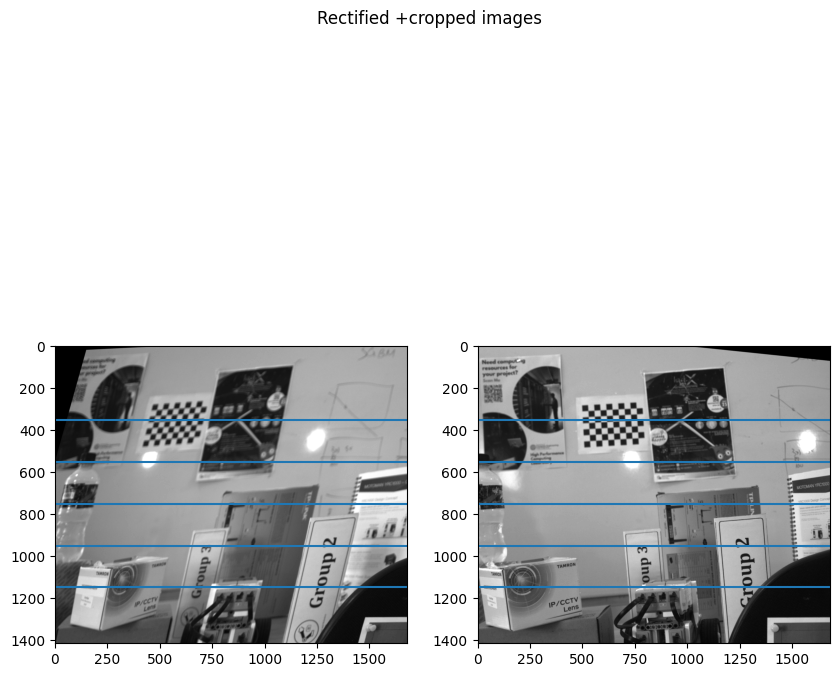

In [353]:
h, w = img1_rectified.shape
x1, x2, y1, y2 = (0,0,0,0)

# Color threshold of the void part
void_th = 160

# List of colors in the vertical an horizontal lines that cross the image in the middle
vertical = [img1_rectified[i, int(w/2)] for i in range(h)]
horizontal = [img1_rectified[int(h/2), i] for i in range(w)]

# Reverses both lists
vertical_rev = vertical[::-1]
horizontal_rev = horizontal[::-1]

# Looks when the change of color is done
for i in range(2,h):
    if vertical[i] > void_th and y1 == 0:
        y1 = i
    if vertical_rev[i] > void_th and y2 == 0:
        y2 = i
    if y1 != 0 and y2 != 0:
        break
for i in range(2,w):
    if horizontal[i] > void_th and x1 == 0:
        x1 = i
    if horizontal_rev[i] > void_th and x2 == 0:
        x2 = i
    if x1 != 0 and x2 != 0:
        break

desired_result1 = img1_rectified[y1:h-y2, x1:w-x2]
desired_result2 = img2_rectified[y1:h-y2, x1:w-x2]

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(desired_result1, cmap="gray")
axes[1].imshow(desired_result2 , cmap="gray")
axes[0].axhline(350)
axes[1].axhline(350)
axes[0].axhline(550)
axes[1].axhline(550)
axes[0].axhline(750)
axes[1].axhline(750)
axes[0].axhline(950)
axes[1].axhline(950)
axes[0].axhline(1150)
axes[1].axhline(1150)
plt.suptitle("Rectified +cropped images")
plt.savefig("./Outputs/rectified_cropped_images.png")
plt.show()

In [ ]:
#Function that Downsamples image x number (reduce_factor) of times. 
def downsample_image(image, reduce_factor):
	for i in range(0,reduce_factor):
		#Check if image is color or grayscale
		if len(image.shape) > 2:
			row,col = image.shape[:2]
		else:
			row,col = image.shape

		image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
	return image

In [ ]:
#Get height and width. Note: It assumes that both pictures are the same size. They HAVE to be same size and height. 
hl,wl = imgL1.shape[:2]
hr,wr = imgR1.shape[:2]

#Get optimal camera matrix for better undistortion 
new_camera_matrix_l, roi_l = cv2.getOptimalNewCameraMatrix(K1,D1,(wl,hl),1,(wl,hl))
new_camera_matrix_r, roi_r = cv2.getOptimalNewCameraMatrix(K2,D2,(wr,hr),1,(wr,hr))


#Undistort images
img_1_undistorted_l = cv2.undistort(imgL1, K1, D1, None, new_camera_matrix_l)
img_2_undistorted_r = cv2.undistort(imgR1, K1, D2, None, new_camera_matrix_r)

img_1_downsampled_l = downsample_image(img_1_undistorted_l,1)
img_2_downsampled_r = downsample_image(img_2_undistorted_r,1)

#cv2.imwrite('undistorted_left.jpg', img_1_downsampled)
#cv2.imwrite('undistorted_right.jpg', img_2_downsampled)

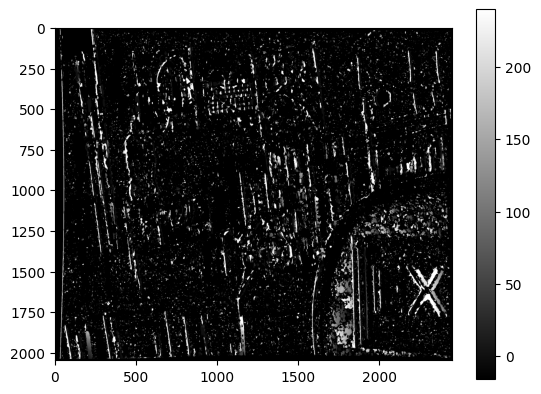

In [ ]:
# Using StereoBM
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
#disparity_BM = stereo.compute(img_1_undistorted_l, img_2_undistorted_r)
disparity_BM = stereo.compute(img_1_undistorted_l, img_2_undistorted_r)
plt.imshow(disparity_BM, "gray")
plt.savefig("./Outputs/stereo_BM_depth_sence_image.png")
plt.colorbar()
plt.show()

In [ ]:
#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 4
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16

#Create Block matching object. 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
	numDisparities = num_disp,
	blockSize = 5,
	uniquenessRatio = 5,
	speckleWindowSize = 5,
	speckleRange = 5,
	disp12MaxDiff = 2,
	P1 = 8*3*win_size**2,#8*3*win_size**2,
	P2 =32*3*win_size**2) #32*3*win_size**2)

In [ ]:
#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img_1_downsampled_l, img_2_downsampled_r)


Computing the disparity  map...


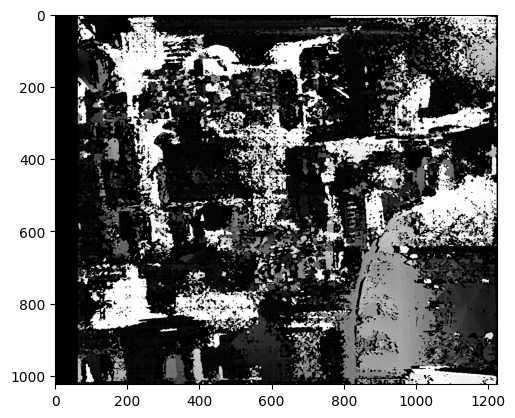

In [358]:
#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity_map , "gray")
plt.savefig("./Outputs/stereo_SGBM_depth_sence_image.png")
plt.show()

In [ ]:

#Reproject points into 3D
points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
#Get color points
colors = cv2.cvtColor(img_1_downsampled_l, cv2.COLOR_BGR2RGB)


In [ ]:
#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()


In [ ]:
#Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]


In [ ]:
#Define name for output file
output_file = 'Outputs/reconstructed.ply'


In [ ]:
#Function to create point cloud file
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [ ]:
#Generate point cloud 
print ("\n Creating the output file... \n")
create_output(output_points, output_colors, output_file)


 Creating the output file... 



In [ ]:
#import open3d as o3d
#point_cloud = o3d.io.read_point_cloud("Outputs/reconstructed.ply", format="ply")
#vis = o3d.visualization.Visualizer()
#vis.create_window()
#vis.get_render_option().point_color_option = o3d.visualization.PointColorOption.Color
#vis.get_render_option().point_size = 3.0
#vis.add_geometry(point_cloud)
#vis.capture_screen_image("Outputs/2D_image_converted_rotated2.jpg", do_render=True)